<h1> Research Project NB 1 </h1>

In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

# Setting Plot Text Size
import matplotlib.pylab as pylab
params = {'legend.fontsize': 14,
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14 }
pylab.rcParams.update(params)

In [2]:
# Loading in Image 

img = nib.load("cdmri11_r.nii")

arr =img.dataobj[:,:,:,:]


In [3]:
arr.shape

(77, 92, 56, 1344)

Text(0.5, 1.0, 'Scan 11 z=25, Parameter Set 30')

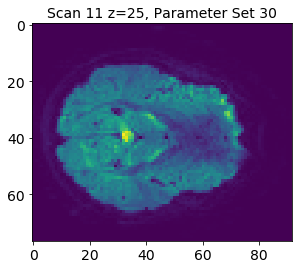

In [4]:
plt.imshow(arr[:,:,25,30])
plt.title('Scan 11 z=25, Parameter Set 30')

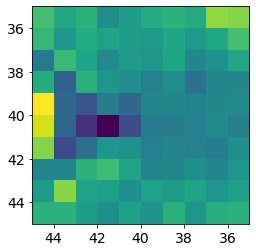

In [5]:
# Plotting Zoomed in view
plt.imshow(arr[35:45,35:45,25,30], extent=[45,35,45,35])

In [6]:
arr[40,40,25,30]

12.284307

Text(0.5, 1.0, 'Voxel Intensity against Parameter Values Set Number')

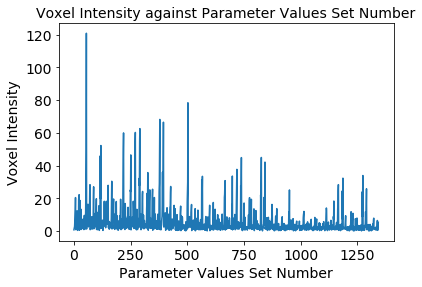

In [7]:
plt.plot(arr[40,40,25,:])
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Voxel Intensity against Parameter Values Set Number')

In [8]:
# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

(1344, 6)

In [9]:
param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,2] = -param[:,2]
param

array([[-7.1803e-01, -5.2602e-01,  4.5578e-01,  3.0000e+03,  2.0000e+01,
         8.0000e+01],
       [-7.1803e-01, -5.2602e-01,  4.5578e-01,  3.0000e+03,  1.2364e+03,
         8.0000e+01],
       [-7.1803e-01, -5.2602e-01,  4.5578e-01,  3.0000e+03,  2.4727e+03,
         8.0000e+01],
       ...,
       [-6.8361e-01,  4.9906e-01, -5.3255e-01,  2.0000e+03,  2.2961e+03,
         1.3000e+02],
       [-6.8361e-01,  4.9906e-01, -5.3255e-01,  2.0000e+03,  3.5325e+03,
         1.3000e+02],
       [-6.8361e-01,  4.9906e-01, -5.3255e-01,  2.0000e+03,  7.3227e+03,
         1.3000e+02]])

In [10]:
b = param[:,3]
TI = param[:,4]
TE = param[:,5]

# Filter based on TI fulfilling condition
vals = TI>TI_limit
indices = np.where(TI>TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]
res_selected = arr[:,:,:,indices]

In [11]:
# From Stackoverflow: https://stackoverflow.com/questions/45637778/how-to-find-intersect-indexes-and-values-in-python
# Function takes unique elements from each array, puts them together, and concatenates
import numpy as np
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

c, idx_b0, ib = intersect_mtlb(indices, b0idx )

s0init = np.mean(arr[:,:,:,idx_b0], axis = 3) 

# Initial Values and Objective Function
b=b/1000
X0 = [300, 1, 1, 1, 0, 0, 0, 1000, 2, 100]; 

In [12]:
# Bounds on the fit
# lower = [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf];
# upper = [inf inf inf inf inf inf inf inf inf inf];

In [13]:
# Creating an Exponential Model Fit

slslice = res_selected[40,40,25,:]
D = 1

def ExpFit(D, b):
    S= np.exp(-b*D)
    return S

S= ExpFit(b, D)
S

array([0.04978707, 0.04978707, 0.04978707, ..., 0.13533528, 0.13533528,
       0.13533528])

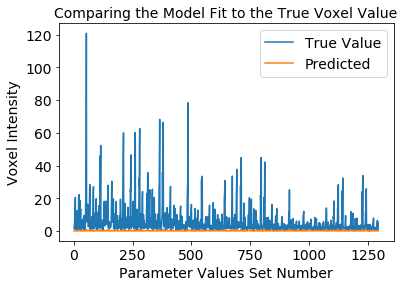

In [14]:
# Plotting the Results

p1 = plt.plot(slslice[0,:])
p2 = plt.plot(S)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing the Model Fit to the True Voxel Value')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

<h2> Fit 1</h2> 

In [15]:
# Simple Exponential Cost Function

def ExpFitCost(D,b, slsice):              # non-default argument cannot follow after default argument (Why?) 
    # create txt / import as global variable 
    S= np.exp(-b*D)
    res = slslice[0,:] -S
    return res


In [16]:
# Quantitatively Evalauting the Model Fit

# Perform Non-Linear Least Squares Fit
from scipy.optimize import least_squares            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
d0 = 0.02
lsr = least_squares(ExpFitCost, d0, args=(b,slslice))
cost = lsr.cost
jac = lsr.jac
value = lsr.x


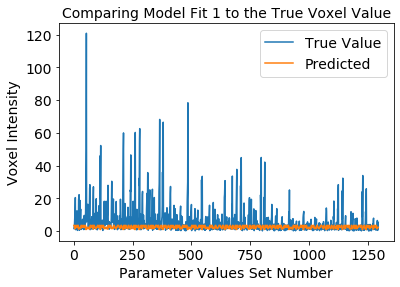

In [17]:
# Plotting Predicted result

S_pred = ExpFit(value, b)
p1 = plt.plot(slslice[0,:])
p2 = plt.plot(S_pred)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing Model Fit 1 to the True Voxel Value')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))
    

<h2> Fit 2 </h2> 

In [18]:
# Fit2 Function

def Fit2(A,D,b):            
    # A: amplitude 
    S= A * np.exp(-b*D)
    return S

# Simple Exponential Cost Function

def Fit2Cost(x, b, slsice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= x[0] * np.exp(-b*x[1])
    res = slslice[0,:] -S
    return res


In [19]:
# Perform Non-Linear Least Squares Fit

d0 = 0.02
A0 = 1
x0 = [A0, d0]
lsr = least_squares(Fit2Cost, x0, args=(b,slslice))
cost = lsr.cost
jac = lsr.jac
values = lsr.x


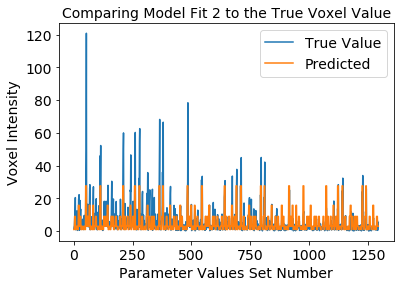

In [20]:
# Plotting Result

S_pred = Fit2(values[0], values[1], b)
p1 = plt.plot(slslice[0,:])
p2 = plt.plot(S_pred)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing Model Fit 2 to the True Voxel Value')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

<h3> Fit 3 </h3> 

In [21]:
# Fit3 Function
# absolute value makes no difference here

def Fit3(x,b, TI, TR):            
    # A: amplitude 
    S= np.abs(x[0] *(1-x[2]* np.exp(-TI/x[3])+np.exp(-TR/x[3]))* np.exp(-b*x[1]))
    return S

# Simple Exponential Cost Function

def Fit3Cost(x, b, TI, TR, slsice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= np.abs(x[0] *(1-x[2]* np.exp(-TI/x[3])+np.exp(-TR/x[3]))* np.exp(-b*x[1]))
    res = slslice[0,:] -S
    return res


In [22]:
# Perform Non-Linear Least Squares Fit

x0 = [1, 0.02, 1, 1]
lsr = least_squares(Fit3Cost, x0, args=(b,TI, TR, slslice))
cost = lsr.cost
jac = lsr.jac
values = lsr.x

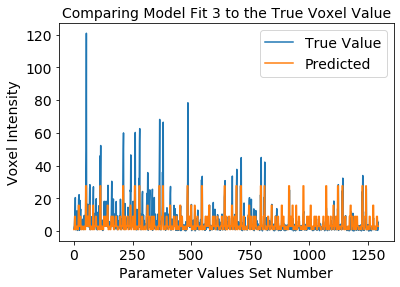

In [23]:
# Plotting Result

S_pred = Fit3(values, b, TI, TR)
p1 = plt.plot(slslice[0,:])
p2 = plt.plot(S_pred)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing Model Fit 3 to the True Voxel Value')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

<h2> Fit 4 </h2> 

In [24]:
# Fit4 Function

def Fit4(x,b, TI, TR, TE):            
    # A: amplitude 
    S= np.abs(x[0] *(1-x[2]* np.exp(-TI/x[3])+np.exp(-TR/x[3]))* np.exp(-TE/x[4])* np.exp(-b*x[1]))
    return S

# Simple Exponential Cost Function

def Fit4Cost(x, b, TI, TR, TE, slsice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= np.abs(x[0] *(1-x[2]* np.exp(-TI/x[3])+np.exp(-TR/x[3]))* np.exp(-TE/x[4])* np.exp(-b*x[1]))
    res = slslice[0,:] -S
    return res

In [25]:
# Perform Non-Linear Least Squares Fit

x0 = [1, 0.02, 1, 1, 10]
# for x[4], values of 0.01, 1 would lead to a straight line at 0, 
# while 10 and 100 works fine

lsr = least_squares(Fit4Cost, x0, args=(b,TI, TR, TE, slslice))
cost = lsr.cost
jac = lsr.jac
values = lsr.x

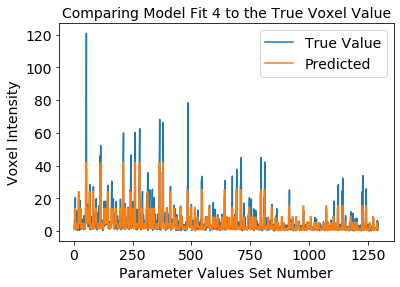

In [26]:
# Plotting Result

S_pred = Fit4(values, b, TI, TR, TE)
p1 = plt.plot(slslice[0,:])
p2 = plt.plot(S_pred)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing Model Fit 4 to the True Voxel Value')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

<h2> Fit 5 </h2>

In [27]:
# Fit5 Function

def Fit5(x,b, TI, TR, TE, param):            

    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    return S

# Simple Exponential Cost Function

def Fit5Cost(x, b, TI, TR, TE, param, slsice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    res = slslice[0,:] -S
    return res

In [28]:
# Perform Non-Linear Least Squares Fit

x0 = [300, 2, 1000, 100, 1, 1, 1, 0, 0, 0]
# for x[4], values of 0.01, 1 would lead to a straight line at 0, 
# while 10 and 100 works fine

lsr = least_squares(Fit5Cost, x0, args=(b,TI, TR, TE, param, slslice))
cost = lsr.cost
jac = lsr.jac
values = lsr.x

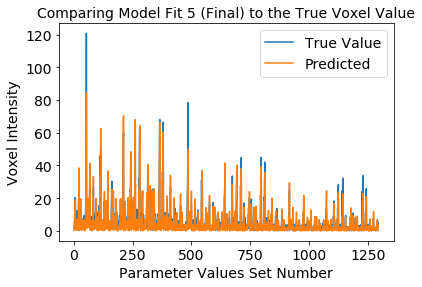

In [29]:
# Plotting Result

S_pred = Fit5(values, b, TI, TR, TE, param)
p1 = plt.plot(slslice[0,:])
p2 = plt.plot(S_pred)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing Model Fit 5 (Final) to the True Voxel Value')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

In [28]:
# Examining Fitted Model Parameters

values

array([ 3.47759233e+06, -1.47510242e-02,  5.03937860e+05,  3.48838526e+01,
        9.97513596e-01,  7.06256000e-01,  7.32190814e-01, -2.07624532e-02,
       -1.18320300e-01, -1.17964625e-02])